In [23]:
from graph_ds import PyH3Graph
from pois_to_h3 import get_pois_h3
import pandas as pd
import h3.api.numpy_int as h3
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np

In [2]:
graph = PyH3Graph()
graph.create(osm_path="../resources/copenhagen-processed.osm.pbf", gtfs_path="../resources/rejseplanen_GTFS.zip")

processing osm pbf file: ../resources/copenhagen-processed.osm.pbf
converted OSM file into 419384 edges
processing osm pbf file: ../resources/copenhagen-processed.osm.pbf
converted OSM file into 405422 edges
osm graph created with (350459,682406) nodes (walk,bike) in 22 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 33 s
merged graph created with 794860 nodes in 2 s
hash: 6672986726594103495


# Get Origins

In [3]:
from ghsl_processing import crop_tif_image, reproject_tif, tif_to_h3
# Open the raster file
tif_path= '../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19.tif'
cropped_tif_file = '../resources/copenhagen_subset.tif'

# paste csv bounding box from this website https://boundingbox.klokantech.com/ 
bbox = [12.3999, 55.6059, 12.7456, 55.7652] # [xmin, ymin, xmax, ymax]

# CROP
# cropping crs from latlon --> tif crs
src_crs = 'EPSG:4326'
dst_crs = 'ESRI:54009'
crop_tif_image(tif_path, cropped_tif_file, bbox, src_crs, dst_crs)

# Reproj
# reprojection goes from tif crs --> latlon 
src_crs = 'ESRI:54009'
dst_crs = 'EPSG:4326'
reprojected_file = '../resources/reprojected_copenhagen.tif'
transformation = reproject_tif(cropped_tif_file, dst_crs, reprojected_file)

H3_RES = 12
h3_csv = '../resources/ghsl_h3_codes.csv'
tif_to_h3(reprojected_file, transformation, h3_csv, H3_RES)

origins = pd.read_csv(h3_csv)
# only take residential, convert to list of h3 indices
origins = list(origins[origins['residential_bool']==1]['h3_index'])

# Get Destinations

In [4]:
pbf_path = "../resources/copenhagen-processed.osm.pbf"

# idea: EVERYONE can use it and live a healthy life with this as their only source
#check: doctors, clinic, health_food, food
#essential filter will be the least restrictive!

# frequency arguments - how often do you use these?
# no workplace - motivate this... unrealistic to get data, and for people to work within 15 minutes of their homes
essential_filter = {
    "amenity":["pharmacy","dentist","clinic","doctors","school"],
    "shop":["supermarket","greengrocer","medical_supply","grocery","wholesale"],
    "healthcare":["clinic","doctor","pharmacy","dentist"],
    "leisure":["park"], "sport":True
    }

# parameters

H3_RES = 12

# n minute city must satisfy the following expression based on
# the existence of certain tags within n minutes:
category_set = set(['pharmacy','park','supermarket','sport', 'education'])

# easy use case which is debateably also essential
#education_filter = {"amenity":["school"]}

osm_tag_mapping = {
    "medical_supply":"pharmacy",
    "greengrocer":"supermarket",
    "wholesale":"supermarket",
    "grocery":"supermarket",
    "clinic":"doctor",
    "doctors":"doctor",
    'pitch':'sport',
    'track':'sport',
    'sports_centre':'sport'
}

h3_df = get_pois_h3(pbf_path, essential_filter, H3_RES, category_set, osm_tag_mapping)

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


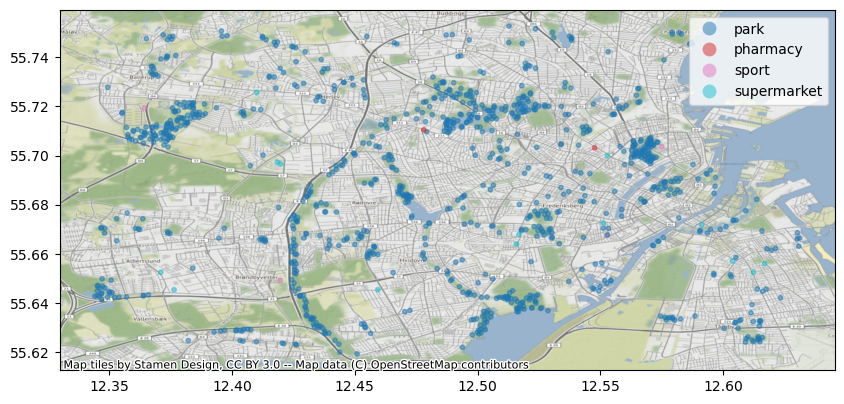

In [10]:
sample_df = h3_df.sample(1000) #df.sample(100)
sample_df[['y','x']] = list(sample_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
# geopandas.points_from_xy(x, y, z=None, crs=None)
gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.x, sample_df.y))

fig, ax = plt.subplots(figsize=(10,10))
# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='category', categorical=True, legend=True, markersize=10, alpha=0.5)

# denmark
#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)

# middle east
#plt.ylim(12.391681,12.737388)
#plt.xlim(55.549206, 55.759991)

cx.add_basemap(ax = ax, crs="EPSG:4326")

/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_84459/1838811508.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined = origins[['h3_index','hex_type']].append(h3_df[['h3_index','hex_type']])


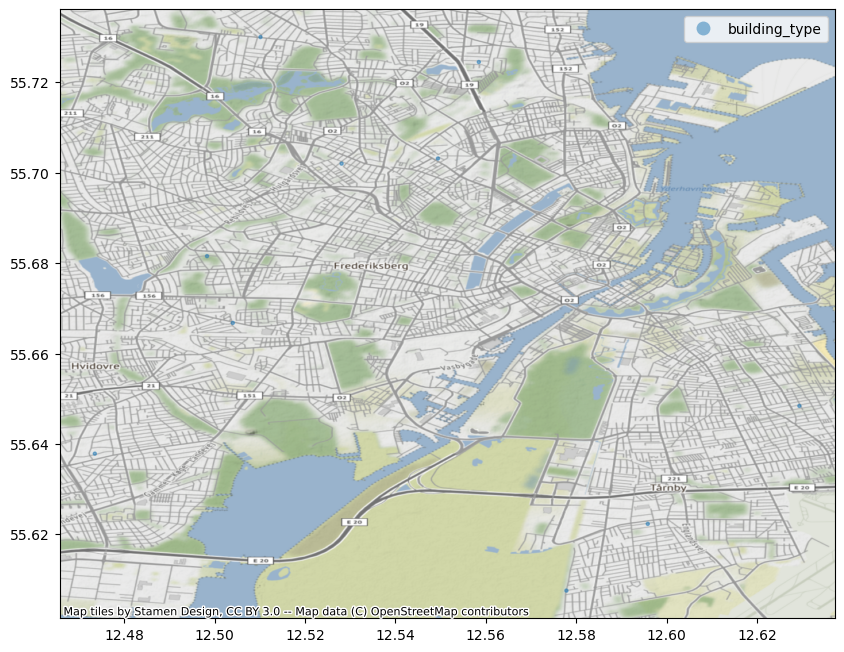

In [62]:
h3_df['hex_type'] = 'poi'
origins = pd.read_csv(h3_csv)
origins = origins[origins['residential_bool']==1]
origins['hex_type'] = 'building_type'
combined = origins[['h3_index','hex_type']].append(h3_df[['h3_index','hex_type']])

sample_df = combined.sample(10) #df.sample(100)
sample_df[['y','x']] = list(sample_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.x, sample_df.y))

fig, ax = plt.subplots(figsize=(10,10))
# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='hex_type', categorical=True, legend=True, markersize=5, alpha=0.5)

#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)

cx.add_basemap(ax = ax, crs="EPSG:4326")

In [66]:
destinations = list(h3_df[h3_df['category']=='supermarket']['h3_index'])
origins = list(origins[origins['residential_bool']==1]['h3_index'])

In [39]:
orgs = [int(x) for x in np.random.choice(origins,10)]
dests = [int(x) for x in np.random.choice(destinations,10)]

In [ ]:
#for each origin for each poi type (run separately), make matrix of routing times

In [42]:
ds = graph.matrix_distance(origins=orgs, destinations=dests, hour_of_week = None)

thread '<unnamed>' panicked at 'index out of bounds: the len is 0 but the index is 0', graph-ds/src/lib.rs:480:thread '<unnamed>' panicked at '41index out of bounds: the len is 0 but the index is 0
', graph-ds/src/lib.rs:480:41
thread '<unnamed>' panicked at 'index out of bounds: the len is 0 but the index is 0', graph-ds/src/lib.rs:480:41
thread '<unnamed>' panicked at 'index out of bounds: the len is 0 but the index is 0', graph-ds/src/lib.rs:480:41
thread '<unnamed>' panicked at 'index out of bounds: the len is 0 but the index is 0', graph-ds/src/lib.rs:480:41
thread '<unnamed>' panicked at 'index out of bounds: the len is 0 but the index is 0', graph-ds/src/lib.rs:480:41
thread '<unnamed>' panicked at 'index out of bounds: the len is 0 but the index is 0', graph-ds/src/lib.rs:480:41
thread '<unnamed>' panicked at 'index out of bounds: the len is 0 but the index is 0', graph-ds/src/lib.rs:480:41
thread '<unnamed>' panicked at 'index out of bounds: the len is 0 but the index is 0', g

PanicException: index out of bounds: the len is 0 but the index is 0